# Evaluation

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.transforms import Affine2D
from scipy.stats import pearsonr
from src import utils
from src import fishfactor

matplotlib.rcParams.update({'font.size': 15})

In [2]:
factor_sets = [i for i in range(10)]
intensity_scales = [20, 50, 80, 100, 150]
bin_res_list = [5, 10, 20, 30, 40]

### PNMF

In [3]:
pnmf_evaluation = []

for factor_set in factor_sets:
    for intensity_scale in intensity_scales:
        for bin_res in bin_res_list:
            try:
                results = pickle.load(open('results/pnmf/factors_%s/intensity_%s/binres_%s.pkl' %(factor_set, intensity_scale, bin_res), 'rb'))
                data = pickle.load(open('../data/pp_sim/data/factors_%s/intensity_%s.pkl' %(factor_set, intensity_scale), 'rb'))

                w_inferred = torch.tensor(results['w'])
                w = data['w']

                z_inferred = torch.tensor(results['z']).view(-1, bin_res, bin_res)
                z_inferred = torch.nn.functional.interpolate(z_inferred.unsqueeze(0), [data['res'], data['res']]).squeeze(0)
                z = data['z']

                inds, correlation = utils.optimal_assignment(z, z_inferred, item_dim=0)
                z_inferred = z_inferred[inds]
                w_inferred = w_inferred[:, inds]
                
                z_corr = pearsonr(z.flatten(), z_inferred.flatten())[0]
                w_corr = pearsonr(w.flatten(), w_inferred.flatten())[0]

            except FileNotFoundError:
                z_corr = 0
                w_corr = 0
                
            df = pd.DataFrame({
                'factor_set' : factor_set,
                'intensity_scale' : intensity_scale,
                'bin_res' : bin_res,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
            }, index=[len(pnmf_evaluation) + 1])
            pnmf_evaluation.append(df)

pnmf_evaluation = pd.concat(pnmf_evaluation)

### NSF

In [4]:
nsf_evaluation = []

for factor_set in factor_sets:
    for intensity_scale in intensity_scales:
        for bin_res in bin_res_list:
            try:
                results = pickle.load(open('results/nsf/factors_%s/intensity_%s/binres_%s.pkl' %(factor_set, intensity_scale, bin_res), 'rb'))
                data = pickle.load(open('../data/pp_sim/data/factors_%s/intensity_%s.pkl' %(factor_set, intensity_scale), 'rb'))

                w_inferred = torch.tensor(results['w'])
                w = data['w']

                z_inferred = torch.tensor(results['z']).view(-1, bin_res, bin_res)
                z_inferred = torch.nn.functional.interpolate(z_inferred.unsqueeze(0), [data['res'], data['res']]).squeeze(0)
                z = data['z']

                inds, correlation = utils.optimal_assignment(z, z_inferred, item_dim=0)
                z_inferred = z_inferred[inds]
                w_inferred = w_inferred[:, inds]
                
                z_corr = pearsonr(z.flatten(), z_inferred.flatten())[0]
                w_corr = pearsonr(w.flatten(), w_inferred.flatten())[0]

            except FileNotFoundError:
                z_corr = 0
                w_corr = 0

            df = pd.DataFrame({
                'factor_set' : factor_set,
                'intensity_scale' : intensity_scale,
                'bin_res' : bin_res,
                'w_corr' : w_corr,
                'z_corr' : z_corr,
            }, index=[len(nsf_evaluation) + 1])
            nsf_evaluation.append(df)

nsf_evaluation = pd.concat(nsf_evaluation)

### FISHFactor

In [5]:
fishfactor_evaluation = []

for factor_set in factor_sets:
    for intensity_scale in intensity_scales:
        results = torch.load('results/fishfactor/factors_%s/intensity_%s.pkl' %(factor_set, intensity_scale), map_location='cpu')
        data = pickle.load(open('../data/pp_sim/data/factors_%s/intensity_%s.pkl' %(factor_set, intensity_scale), 'rb'))
        df = pd.DataFrame(data['data'].numpy())
        df.columns = ['x', 'y', 'feature']
        df['group'] = 0

        w_inferred = results['pyro_params']['w_loc_raw'].cpu().detach().squeeze(-1)
        w_inferred = torch.nn.Softplus()(w_inferred).squeeze()
        w = data['w']

        model = fishfactor.FISHFactor(
            data=df,
            n_latents=results['K'],
            n_inducing=results['n_inducing'],
            grid_resolution=results['grid_resolution'],
            device='cpu'
        )

        model.load_state_dict(results['state_dict'])
        for m in range(model.M):
            model.gp_list[m].load_state_dict(results['gp_state_dicts'][m])

        axis = torch.linspace(0, 1, data['res'])
        xx, yy = torch.meshgrid([axis, axis])
        grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

        mask = model.masks[0].view(results['grid_resolution'], results['grid_resolution']).to(dtype=torch.float32)
        mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), [data['res'], data['res']]).squeeze(0).squeeze(0)
        mask = mask.to(dtype=torch.bool)

        z_inferred = utils.gp_percentiles(model.gp_list[0], grid)[0].view(-1, data['res'], data['res'])
        z_inferred = torch.nn.Softplus()(z_inferred)
        z_inferred = torch.transpose(z_inferred, -1, -2)
        z_inferred *= mask.unsqueeze(0)

        z = data['z']

        inds, correlation = utils.optimal_assignment(z, z_inferred, item_dim=0)
        z_inferred = z_inferred[inds]
        w_inferred = w_inferred[:, inds]

        z_corr = pearsonr(z.flatten(), z_inferred.flatten())[0]
        w_corr = pearsonr(w.flatten(), w_inferred.flatten())[0]

        df = pd.DataFrame({
            'factor_set' : factor_set,
            'intensity_scale' : intensity_scale,
            'w_corr' : w_corr,
            'z_corr' : z_corr,
        }, index=[len(fishfactor_evaluation) + 1])

        fishfactor_evaluation.append(df)

fishfactor_evaluation = pd.concat(fishfactor_evaluation)

### Comparison

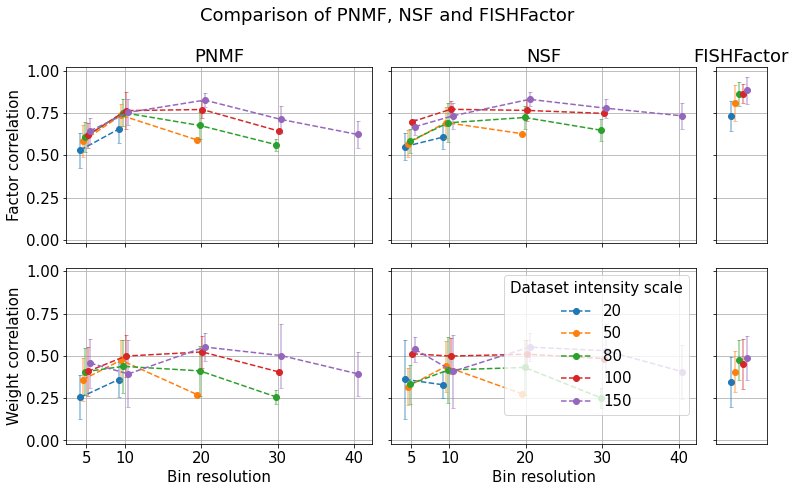

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(11, 7), sharey=True, gridspec_kw={'width_ratios': [3, 3, 0.5]})
fig.suptitle('Comparison of PNMF, NSF and FISHFactor')

x_shifts = np.linspace(-0.80, 0.80, 6)
for i, intensity_scale in enumerate(intensity_scales):
    pnmf_z = pnmf_evaluation[(pnmf_evaluation.intensity_scale==intensity_scale) & (pnmf_evaluation.z_corr!=0)].groupby(['bin_res']).z_corr
    pnmf_w = pnmf_evaluation[(pnmf_evaluation.intensity_scale==intensity_scale) & (pnmf_evaluation.w_corr!=0)].groupby(['bin_res']).w_corr
    nsf_z = nsf_evaluation[(nsf_evaluation.intensity_scale==intensity_scale) & (nsf_evaluation.z_corr!=0)].groupby(['bin_res']).z_corr
    nsf_w = nsf_evaluation[(nsf_evaluation.intensity_scale==intensity_scale) & (nsf_evaluation.w_corr!=0)].groupby(['bin_res']).w_corr
    fishfactor_z = fishfactor_evaluation[fishfactor_evaluation.intensity_scale==intensity_scale].z_corr
    fishfactor_w = fishfactor_evaluation[fishfactor_evaluation.intensity_scale==intensity_scale].w_corr

    transform = Affine2D().translate(x_shifts[i], 0.0) + axs[0][0].transData
    axs[0][0].errorbar(x=pnmf_z.mean().index, y=pnmf_z.mean(), yerr=pnmf_z.std(), transform=transform, linestyle='', marker='', alpha=0.5, c='C%s' %i, capsize=2)
    axs[0][0].plot(pnmf_z.mean().index, pnmf_z.mean(), transform=transform, linestyle='--', marker='o', c='C%s' %i)
    axs[0][0].set_title('PNMF')
    axs[0][0].set_xticks(bin_res_list)
    axs[0][0].set_xticklabels([])
    axs[0][0].set_ylim(-0.02, 1.02)

    transform = Affine2D().translate(x_shifts[i], 0.0) + axs[0][1].transData
    axs[0][1].errorbar(x=nsf_z.mean().index, y=nsf_z.mean(), yerr=nsf_z.std(), transform=transform, linestyle='', marker='', alpha=0.5, c='C%s' %i, capsize=2)
    axs[0][1].plot(nsf_z.mean().index, nsf_z.mean(), transform=transform, linestyle='--', marker='o', c='C%s' %i)
    axs[0][1].set_title('NSF')
    axs[0][1].set_xticks(bin_res_list)
    axs[0][1].set_xticklabels([])
    axs[0][1].set_ylim(-0.02, 1.02)

    transform = Affine2D().translate(x_shifts[i], 0.0) + axs[0][2].transData
    axs[0][2].errorbar(x=[0], y=[fishfactor_z.mean()], yerr=[fishfactor_z.std()], transform=transform, marker='', alpha=0.5, c='C%s' %i, capsize=2)
    axs[0][2].plot([0], [fishfactor_z.mean()], transform=transform, marker='o', c='C%s' %i)
    axs[0][2].set_title('FISHFactor')
    axs[0][2].set_xlim(-2, 2)
    axs[0][2].set_xticks([])

    transform = Affine2D().translate(x_shifts[i], 0.0) + axs[1][0].transData
    axs[1][0].errorbar(x=pnmf_w.mean().index, y=pnmf_w.mean(), yerr=pnmf_w.std(), transform=transform, linestyle='', marker='', alpha=0.5, c='C%s' %i, capsize=2)
    axs[1][0].plot(pnmf_w.mean().index, pnmf_w.mean(), transform=transform, linestyle='--', marker='o', c='C%s' %i)
    axs[1][0].set_xlabel('Bin resolution')
    axs[1][0].set_xticks(bin_res_list)
    axs[1][0].set_xticklabels(bin_res_list)
    axs[1][0].set_ylim(-0.02, 1.02)

    transform = Affine2D().translate(x_shifts[i], 0.0) + axs[1][1].transData
    axs[1][1].errorbar(x=nsf_w.mean().index, y=nsf_w.mean(), yerr=nsf_w.std(), transform=transform, linestyle='', marker='', alpha=0.5, c='C%s' %i, capsize=2)
    axs[1][1].plot(nsf_w.mean().index, nsf_w.mean(), transform=transform, label=intensity_scale, linestyle='--', marker='o', c='C%s' %i)
    axs[1][1].set_xlabel('Bin resolution')
    axs[1][1].set_xticks(bin_res_list)
    axs[1][1].set_xticklabels(bin_res_list)
    axs[1][1].set_ylim(-0.02, 1.02)

    transform = Affine2D().translate(x_shifts[i], 0.0) + axs[1][2].transData
    axs[1][2].errorbar(x=[0], y=[fishfactor_w.mean()], yerr=[fishfactor_w.std()], transform=transform, marker='', alpha=0.5, c='C%s' %i, capsize=2)
    axs[1][2].plot([0], [fishfactor_w.mean()], transform=transform, marker='o', c='C%s' %i)
    axs[1][2].set_xlim(-2, 2)
    axs[1][2].set_xticks([])

for ax in axs.flatten():
    ax.grid()

axs[0][0].set_ylabel('Factor correlation')
axs[1][0].set_ylabel('Weight correlation')
axs[1][1].legend(title='Dataset intensity scale')

plt.tight_layout()
plt.show()